# Install & Import Libraries

In [1]:
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install transformers
!pip install gensim 
!pip install torch
!pip install hf_xet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 11.3 MB/s eta 0:00:02
     ------------------------------ -------- 10.0/12.8 MB 31.1 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 28.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import TreebankWordTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import hf_xet
import pandas as pd
import spacy
import pandas as pd
from gensim import corpora
from gensim.models.ldaseqmodel import LdaSeqModel

# Load Data

In [77]:
df_transcripts = pd.read_csv('debate_transcripts_cleaned.csv', encoding='utf-8')

In [82]:
df_transcripts = df_transcripts[df_transcripts["is_candidate"] == True].copy()

# Add First Names of Candidates

In [110]:
candidate_first_names = {
    # 🟦 Democratic Presidential Candidates
    "Kennedy": "John",
    "Humphrey": "Hubert",
    "McGovern": "George",
    "Carter": "Jimmy",
    "Mondale": "Walter",
    "Dukakis": "Michael",
    "Clinton (Bill)": "Bill",
    "Clinton Bill": "Bill",
    "Gore": "Al",
    "Kerry": "John",
    "Obama": "Barack",
    "Clinton Hillary": "Hillary",
    "Biden": "Joe",

    # 🟥 Republican Presidential Candidates
    "Nixon": "Richard",
    "Goldwater": "Barry",
    "Ford": "Gerald",
    "Reagan": "Ronald",
    "Bush Sr": "George",  # H. W. or W., disambiguate by year
    "Bush Jr": "George",  # H. W. or W., disambiguate by year
    "Dole": "Bob",
    "Mccain": "John",
    "Romney": "Mitt",
    "Trump": "Donald",
    "DeSantis": "Ron",
    "Kemp": "Jack",

    # 🟨 Independents / Third-party
    "Wallace": "George",
    "Perot": "Ross",
    "Kennedy Jr.": "Robert",
    "West": "Cornel",
    "Ramaswamy": "Vivek",
    "Anderson": "John",

    # ✅ Vice Presidential Candidates (some later became president)
    "Johnson": "Lyndon",
    "Agnew": "Spiro",
    "Rockefeller": "Nelson",
    "Muskie": "Edmund",
    "Miller": "William",
    "Ferraro": "Geraldine",
    "Quayle": "Dan",
    "Lieberman": "Joe",
    "Edwards": "John",
    "Palin": "Sarah",
    "Ryan": "Paul",
    "Pence": "Mike",
    "Harris": "Kamala",
    "Cheney": "Dick",
    "Bentsen": "Lloyd",
    "Kaine": "Tim",
    "Stockdale": "James",
    "Walz": "Tim",
    "Vance": "J.D."
}

df_transcripts["first_name"] = df_transcripts["actor"].map(candidate_first_names)

In [94]:
df_transcripts.head()

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,first_name
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,John
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,Richard
5,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, the Vice President and I came to the Con...",True,Democratic,True,False,False,John
7,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,I have no comment.,True,Republican,False,False,False,Richard
10,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,It would be rather difficult to cover them in ...,True,Republican,False,False,False,Richard


# Preprocess Data

In [112]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tokenizers')
nltk.download('punkt')

# Initialize tools
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing text
def text_preprocess(text):
    if pd.isnull(text):
        return ""
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return " ".join(lemmatized_tokens)

# Apply to your dataframe
df_transcripts["cleaned_text"] = df_transcripts["dialogue"].apply(text_preprocess)

# Preview
df_transcripts[["dialogue", "cleaned_text"]].head(10)

[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading tokenizers: Package 'tokenizers' not found
[nltk_data]     in index
[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,dialogue,cleaned_text
0,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith election abraham lincoln said question w...
2,"Mr. Smith, Senator Kennedy. The things that Se...",smith senator thing senator kennedy said many ...
5,"Well, the Vice President and I came to the Con...",well vice president came congress together ser...
7,I have no comment.,comment
10,It would be rather difficult to cover them in ...,would rather difficult cover eight two half wo...
11,"Well, I would say in the latter that the and ...",well would say latter thats found uh somewhat ...
14,Thats correct.,thats correct
16,"Well, because I think that if the federal gove...",well think federal government moved program wi...
20,"Well, I would suggest, Mr. Vanocur, that uh i...",well would suggest vanocur uh know president p...
22,"Well, Ill just say that the question is of exp...",well ill say question experience question also...


# Remove "NON-NOUNS and NON-ADJECTIVES"

Non-Nouns and Non-Adjectives were deemed not necessary to identify topics across the political landscape

In [124]:
# Lade spaCy Modell
nlp = spacy.load("en_core_web_sm")

# Funktion zum Filtern von NOUN, ADJ, PROPN
def keep_nouns_adjectives_spacy(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text)
    return " ".join([token.text.lower() for token in doc if token.pos_ in {"NOUN", "PROPN"}])

# Anwenden auf DataFrame
df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(keep_nouns_adjectives_spacy)

# Identify and Remove "Domain-specific Stopwords"

Remove Candidate Names

In [129]:
# Step 1: Collect all lowercase actor names
actor_words_to_remove = set(df_transcripts['actor'].dropna().str.lower().str.strip())

# Step 2: Collect all lowercase first names from your mapping
first_names_to_remove = set(name.lower() for name in candidate_first_names.values())

# Step 3: Combine into one set of stopwords
names_to_remove = actor_words_to_remove.union(first_names_to_remove)
names_to_remove.update(["clinton", "bush"])

# Step 4: Define a clean-up function
def remove_names(text):
    if pd.isnull(text):
        return text
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word.lower() not in names_to_remove]
    return " ".join(cleaned_tokens)

# Step 5: Apply to cleaned_text column
df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(remove_names)

Remove Words with less than 3 characters

In [126]:
def remove_short_words(text):
    if pd.isnull(text):
        return text
    tokens = text.split()
    filtered_tokens = [word for word in tokens if len(word) >= 3]
    return " ".join(filtered_tokens)

df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(remove_short_words)

Identify Frequent Words without Topic Contribution

In [130]:
from collections import Counter
import pandas as pd

# Combine all cleaned text into one long string
all_text = " ".join(df_transcripts["cleaned_text"].dropna())

# Split into words
words = all_text.split()

# Count frequency
word_counts = Counter(words)

# Get the 200 most common words
top_300_df = word_counts.most_common(300)

# Ensure all rows are shown
pd.set_option('display.max_rows', 300)

# Display interactively
top_300_df

[('people', 3121),
 ('president', 2265),
 ('tax', 1632),
 ('year', 1609),
 ('country', 1388),
 ('state', 1329),
 ('thing', 1161),
 ('time', 1096),
 ('job', 946),
 ('america', 897),
 ('way', 874),
 ('united', 852),
 ('senator', 828),
 ('government', 779),
 ('world', 769),
 ('american', 655),
 ('governor', 646),
 ('lot', 638),
 ('fact', 624),
 ('health', 618),
 ('money', 615),
 ('care', 576),
 ('administration', 569),
 ('family', 567),
 ('plan', 560),
 ('program', 556),
 ('number', 529),
 ('security', 522),
 ('war', 502),
 ('percent', 488),
 ('problem', 482),
 ('business', 470),
 ('question', 466),
 ('nation', 463),
 ('economy', 458),
 ('work', 453),
 ('child', 452),
 ('policy', 430),
 ('congress', 425),
 ('day', 412),
 ('kind', 406),
 ('issue', 396),
 ('school', 391),
 ('talk', 387),
 ('woman', 377),
 ('part', 356),
 ('budget', 356),
 ('vice', 355),
 ('energy', 345),
 ('life', 343),
 ('law', 331),
 ('dollar', 330),
 ('education', 330),
 ('cut', 323),
 ('rate', 308),
 ('record', 307),
 (

 Remove President Names:

In [14]:
# STEP 4: Collect lowercase actor names to remove as well
actor_words_to_remove = set(df_transcripts['actor'].dropna().str.lower().str.strip())

In [143]:
from collections import Counter

# STEP 1: Collect top 300 most frequent words
all_text = " ".join(df_transcripts["cleaned_text"].dropna())
top_words = [word for word, _ in Counter(all_text.split()).most_common(300)]

# STEP 2: Define exception list (keep these even if frequent)
exception_words = {
    "tax", "job", "health", "money", "care", "family", "plan", "program",
    "security", "war", "business", "nation", "economy", "work", "child", "school", "woman", "budget", "energy",
    "life", "law", "dollar", "education", "cut", "rate", "record", "system", "weapon", "drug", "deal", "company",
    "iraq", "troop", "support", "home", "cost", "oil", "force", "course", "defense", "opportunity", "position",
    "reform", "deficit", "medicare", "china", "iran", "man", "leadership", "election", "insurance", "income",
    "control", "house", "trade", "case", "kid", "hope", "power", "increase", "credit", "line", "community", "peace",
    "union", "soviet", "russia", "ally", "court", "folk", "growth", "spending", "agreement", "debt", "freedom",
    "city", "order", "effort", "border", "chance", "class", "college", "new", "teacher", "action", "value", "threat",
    "act", "parent", "strength", "afghanistan", "gun", "crime", "inflation", "member", "arm", "commitment",
    "experience", "first", "help", "side", "unemployment", "group", "israel", "price", "others", "level", "middle",
    "taxpayer", "market", "worker", "ill", "pay", "street", "national", "justice", "trust", "saddam", "citizen",
    "north", "jim", "white", "investment", "benefit", "men", "housing", "fund", "east", "service",
    "sanction", "abortion", "police", "use", "crisis", "regard", "progress", "industry", "judge", "right",
    "military", "land", "attack", "period", "amendment", "mistake", "opponent", "legislation", "welfare", "call",
    "nuclear", "bin", "enforcement", "korea", "priority", "air", "regulation", "love", "aid", "intelligence",
    "prescription", "coal", "son", "hussein", "wall", "couple", "relationship", "result", "rest", "supreme",
    "europe", "mother", "doctor", "putin", "student", "sense", "missile", "technology", "gas",
    "belief", "environment", "resource", "balance", "fight", "faith", "role", "race", "loan", "head", "food",
    "recession", "treaty", "capital", "plant", "car", "development", "incentive", "california", "product"
}

# STEP 3: Compute frequent words to remove (exclude exceptions)
frequent_words_to_remove = set(top_words) - exception_words

# STEP 4: Add lowercase actor names to removal list
actor_words_to_remove = set(df_transcripts["actor"].dropna().str.lower().str.strip())

# Optional STEP 5: Define extra political terms (if you intend to use this)
political_terms = set()  # or define as: {"president", "candidate", "campaign", ...}

# STEP 6: Combine all words to remove (lowercase)
words_to_remove = frequent_words_to_remove.union(political_terms).union(actor_words_to_remove)

# STEP 7: Clean function with case-insensitive filtering
def clean_with_exceptions(text):
    if pd.isnull(text):
        return ""
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in words_to_remove]
    return " ".join(filtered_tokens)

# STEP 8: Apply to DataFrame
df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(clean_with_exceptions)

# STEP 9: Preview result
df_transcripts[["actor", "dialogue", "cleaned_text"]].head(10)

,actor,dialogue,cleaned_text
0,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith election abraham lincoln nation election...
1,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",smith discus internal nation men kremlin men r...
2,Kennedy,"Well, the Vice President and I came to the Con...",period experience program advocate record wood...
4,Nixon,It would be rather difficult to cover them in ...,trip trip increase exchange program exchange t...
5,Kennedy,"Well, I would say in the latter that the and ...",war difficulty period transition price control...
6,Kennedy,"Well, because I think that if the federal gove...",program support plant spring harvest control m...
7,Nixon,"Well, I would suggest, Mr. Vanocur, that uh i...",improper member family advice cabinet adviser ...
8,Kennedy,"Well, Ill just say that the question is of exp...",experience abraham lincoln session house repre...
9,Kennedy,I didnt indicate. I did not advocate reducing ...,debt debt security debt
10,Kennedy,"reducing the interest rate. In my judgment, t...",money money economy recession recession activi...


In [132]:
# Drop rows where cleaned_text is empty or just whitespace
df_transcripts = df_transcripts[df_transcripts["cleaned_text"].str.strip() != ""]

# Reset index if desired
df_transcripts.reset_index(drop=True, inplace=True)

# Preview the result
df_transcripts.head(10)

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,first_name,cleaned_text,cleaned_text_no_names
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,John,smith election abraham lincoln nation election...,smith election abraham lincoln question nation...
1,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,Richard,smith discus internal affair nation competitio...,smith senator thing senator many question disc...
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, the Vice President and I came to the Con...",True,Democratic,True,False,False,John,labor period experience program advocate recor...,vice president congress labor year period time...
3,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,I have no comment.,True,Republican,False,False,False,Richard,comment,comment
4,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,It would be rather difficult to cover them in ...,True,Republican,False,False,False,Richard,half trip recommendation trip increase exchang...,difficult half proposal first foreign trip rec...
5,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, I would say in the latter that the and ...",True,Democratic,True,False,False,John,figure speech truman truman war difficulty per...,latter unsatisfactory figure previous speech t...
6,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, because I think that if the federal gove...",True,Democratic,True,False,False,John,program support farmer plant spring harvest co...,federal government program support economic fa...
7,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Well, I would suggest, Mr. Vanocur, that uh i...",True,Republican,False,False,False,Richard,improper instance member family recommendation...,president facetious statement improper preside...
8,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, Ill just say that the question is of exp...",True,Democratic,True,False,False,John,experience future goal abraham lincoln preside...,ill question experience question judgment futu...
9,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,I didnt indicate. I did not advocate reducing ...,True,Democratic,True,False,False,John,debt debt obligation security debt,federal debt able federal debt heavy obligatio...


In [133]:
from gensim import corpora

# Step 1: Tokenize cleaned text
texts = df_transcripts["cleaned_text"].dropna().apply(str.split).tolist()

# Step 2: Create dictionary from tokenized texts
dictionary = corpora.Dictionary(texts)

# Step 3: Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.3)

# Step 4: Print number of remaining tokens
print(f"Remaining tokens after filtering: {len(dictionary)}")

Remaining tokens after filtering: 1888


# LDA across ALL years

Assumption: Each Speech is treated as a Document

In [26]:
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd

# Step 1: Tokenize cleaned text
texts = df_transcripts["cleaned_text"].dropna().apply(str.split).tolist()

# Step 2: Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 3: Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, random_state=42, passes=100)

# Step 4: Show all topics
all_topics = lda_model.show_topics(num_topics=-1, num_words=10, formatted=True)

for topic_id, topic_words in all_topics:
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.080*"security" + 0.064*"social" + 0.029*"penny" + 0.012*"trust" + 0.010*"medicare" + 0.009*"committee" + 0.009*"benefit" + 0.008*"inaudible" + 0.008*"iranian" + 0.008*"release"
Topic 1: 0.042*"world" + 0.031*"nuclear" + 0.019*"nation" + 0.019*"iran" + 0.017*"war" + 0.016*"soviet" + 0.015*"weapon" + 0.015*"russia" + 0.012*"middle" + 0.011*"peace"
Topic 2: 0.069*"health" + 0.069*"care" + 0.031*"plan" + 0.026*"drug" + 0.026*"insurance" + 0.023*"family" + 0.022*"cost" + 0.021*"medicare" + 0.015*"reform" + 0.015*"government"
Topic 3: 0.023*"word" + 0.020*"trade" + 0.020*"vote" + 0.012*"guy" + 0.011*"car" + 0.011*"open" + 0.010*"agreement" + 0.009*"liberal" + 0.008*"history" + 0.008*"latin"
Topic 4: 0.040*"woman" + 0.034*"issue" + 0.032*"court" + 0.023*"abortion" + 0.018*"decision" + 0.018*"statement" + 0.017*"supreme" + 0.015*"voter" + 0.014*"gentleman" + 0.014*"judge"
Topic 5: 0.029*"joe" + 0.021*"law" + 0.013*"black" + 0.012*"hillary" + 0.011*"ill" + 0.011*"young" + 0.010*"prou

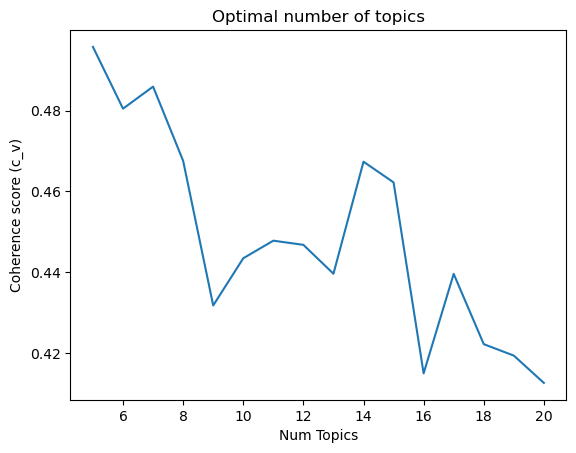

In [13]:
coherence_values = []
topic_range = range(5, 21, 1)

for num_topics in topic_range:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plot coherence scores
import matplotlib.pyplot as plt
plt.plot(topic_range, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (c_v)")
plt.title("Optimal number of topics")
plt.show()

In [28]:
import pandas as pd
from collections import defaultdict

topic_labels = {
    0:  "Social Security, Medicare & Middle East Relations",
    1:  "Nuclear Policy, Global Diplomacy & Foreign Threats",
    2:  "Healthcare, Insurance Reform & Medical Costs",
    3:  "Trade Agreements, Voting & Political Rhetoric",
    4:  "Abortion Rights, Supreme Court Decisions & Gender Issues",
    5:  "Candidate Identity, Personal Narratives & Social Justice",
    6:  "Gun Violence, Crime Policy & Debate Proceedings",
    7:  "Government Programs, Urban Policy & Systemic Challenges",
    8:  "Immigration, Border Policy & Vice Presidential Debate Focus",
    9:  "Military Intervention, Defense Strategy & War in the Middle East",
    10: "Education, Youth Programs & Community Development",
    11: "China Policy, Global Trade & Public Reactions",
    12: "Debate Moments, Rhetoric & Voter Sentiment",
    13: "Energy Policy, Fossil Fuels & Clean Technology",
    14: "Taxation, Economic Growth & Fiscal Strategy"
}

# Step 1: Create mapping from document index to year
doc_years = df_transcripts["year"].reset_index(drop=True)

# Step 2: Get topic distribution for each document
doc_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)

# Step 3: Aggregate topic weights by year
year_topic_weights = defaultdict(lambda: [0.0] * lda_model.num_topics)

for doc_id, topic_dist in enumerate(doc_topics):
    year = doc_years[doc_id]
    for topic_id, weight in topic_dist:
        year_topic_weights[year][topic_id] += weight

# Step 4: Convert to DataFrame
year_topic_df = pd.DataFrame.from_dict(year_topic_weights, orient='index')
year_topic_df.index.name = "year"
year_topic_df.columns = [topic_labels.get(i, f"Topic {i}") for i in range(lda_model.num_topics)]

# Step 5: Normalize topic weights per year
year_topic_df = year_topic_df.div(year_topic_df.sum(axis=1), axis=0)

# Step 6: Preview
print(year_topic_df.round(3).head(10))

      Social Security, Medicare & Middle East Relations  \
year                                                      
1960                                              0.043   
1976                                              0.058   
1980                                              0.076   
1984                                              0.062   
1988                                              0.056   
1992                                              0.035   
1996                                              0.053   
2000                                              0.050   
2004                                              0.037   
2008                                              0.049   

      Nuclear Policy, Global Diplomacy & Foreign Threats  \
year                                                       
1960                                              0.119    
1976                                              0.122    
1980                                              0

/tmp/ipykernel_354/3485045084.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', year_topic_df.shape[1]).colors


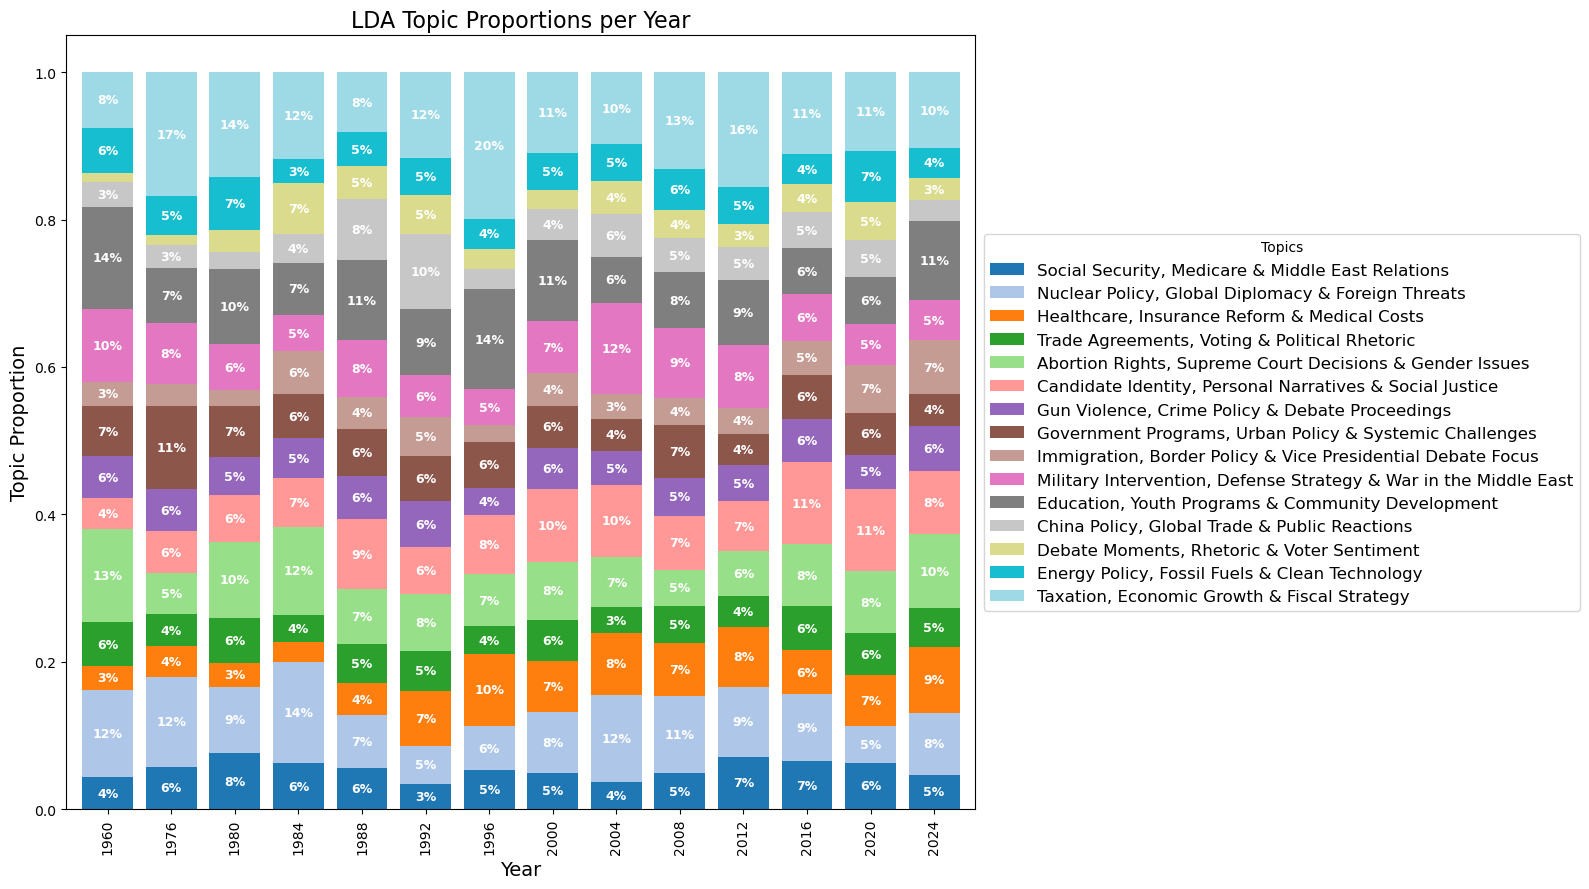

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Optional: Sort years
year_topic_df = year_topic_df.sort_index()

# Create colormap
colors = cm.get_cmap('tab20', year_topic_df.shape[1]).colors

# Plot settings
fig, ax = plt.subplots(figsize=(16, 9))
bars = year_topic_df.plot(
    kind='bar',
    stacked=True,
    color=colors,
    width=0.8,
    ax=ax
)

# Add percentage labels
for i, year in enumerate(year_topic_df.index):
    y_offset = 0
    for j, topic in enumerate(year_topic_df.columns):
        value = year_topic_df.loc[year, topic]
        if value > 0.03:  # Only label if > 3% for readability
            ax.text(
                i,
                y_offset + value / 2,
                f"{value:.0%}",
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                weight='bold'
            )
        y_offset += value

# Labels and legend
ax.set_title("LDA Topic Proportions per Year", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Topic Proportion", fontsize=14)
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    title="Topics",
    fontsize=12
)

plt.tight_layout()
plt.show()

# Dynamic Topic Modelling

Topics: 3, Coherence: 0.5474
Topics: 4, Coherence: 0.5200
Topics: 5, Coherence: 0.4735
Topics: 6, Coherence: 0.4660
Topics: 7, Coherence: 0.4743
Topics: 8, Coherence: 0.4289
Topics: 9, Coherence: 0.4088
Topics: 10, Coherence: 0.4278
Topics: 11, Coherence: 0.4497
Topics: 12, Coherence: 0.3996
Topics: 13, Coherence: 0.4622
Topics: 14, Coherence: 0.4653
Topics: 15, Coherence: 0.4393
Topics: 16, Coherence: 0.4441
Topics: 17, Coherence: 0.4340
Topics: 18, Coherence: 0.4220
Topics: 19, Coherence: 0.4286
Topics: 20, Coherence: 0.4412


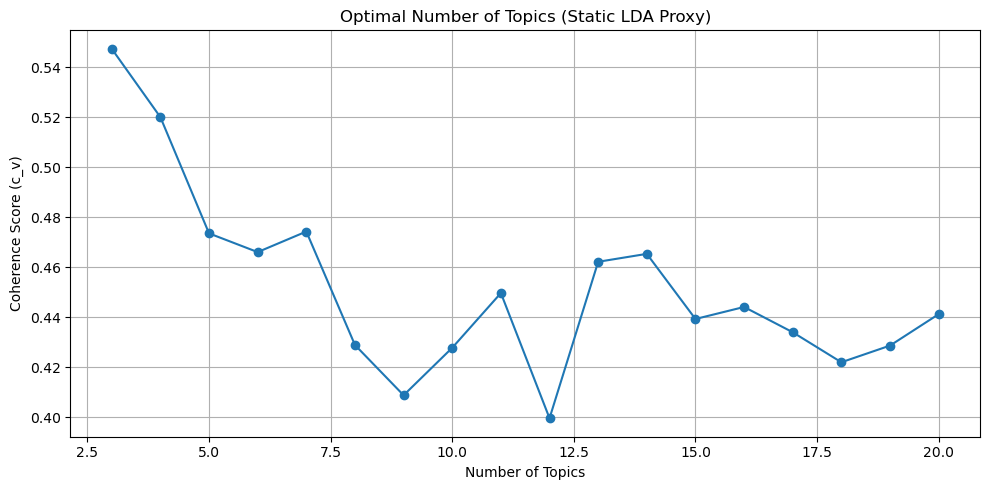

In [144]:
# Prepare corpus and dictionary (you already have these)
texts = all_docs  # your tokenized documents
corpus = [dictionary.doc2bow(text) for text in texts]

# Try a range of topic numbers
topic_range = range(3, 21)  # You can adjust range
coherence_scores = []

for num_topics in topic_range:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=42
    )
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    print(f"Topics: {num_topics}, Coherence: {coherence:.4f}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.title("Optimal Number of Topics (Static LDA Proxy)")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:
# Step 1: Preprocessing - tokenize and filter short texts
df_transcripts = df_transcripts.dropna(subset=["cleaned_text"])
df_transcripts["tokens"] = df_transcripts["cleaned_text"].apply(lambda x: x.split())

# Step 2: Group token lists by year
grouped = df_transcripts.groupby("year")["tokens"].apply(list).sort_index()

# Step 3: Flatten into one doc per speech (not per year!)
all_docs = [doc for year_docs in grouped for doc in year_docs]
timeslices = [len(year_docs) for year_docs in grouped]

# Step 4: Dictionary + filtering
dictionary = corpora.Dictionary(all_docs)
corpus = [dictionary.doc2bow(text) for text in all_docs]

# Step 5: Train Dynamic Topic Model (default/full settings)
ldaseq = LdaSeqModel(
    corpus=corpus,
    time_slice=timeslices,
    id2word=dictionary,
    num_topics=7,
    initialize='gensim',
    random_state=42
)

# Step 6: Print top terms in each topic over time
for topic_id in range(7):
    print(f"\n=== Topic {topic_id} ===")
    for t, year in enumerate(grouped.index):
        terms = ldaseq.print_topic(topic=topic_id, time=t, top_terms=10)
        print(f"Year {year}: {terms}")

/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/li


=== Topic 0 ===
Year 1960: [('woman', 0.023173820425659), ('family', 0.01990151842816086), ('life', 0.019745050832470235), ('law', 0.019655889957349515), ('child', 0.01952496975018536), ('house', 0.018887544169890733), ('city', 0.0167871684052454), ('man', 0.014291935633031333), ('crime', 0.013119774858266504), ('gun', 0.011378154545963385)]
Year 1976: [('woman', 0.023928028808886007), ('family', 0.02027229638968928), ('law', 0.02010078124825535), ('life', 0.019879757461200853), ('child', 0.01952189473847076), ('house', 0.018168332267575207), ('city', 0.01704931212975132), ('man', 0.01379631902456146), ('crime', 0.013360558116152176), ('gun', 0.011559067199406824)]
Year 1980: [('woman', 0.026309411028073222), ('family', 0.02132885968905878), ('life', 0.020751594463891895), ('law', 0.02072793313585721), ('child', 0.020134824870328076), ('city', 0.016941014331578005), ('house', 0.016588781673297297), ('man', 0.013628749317704286), ('crime', 0.013106350815816603), ('job', 0.0112960697552

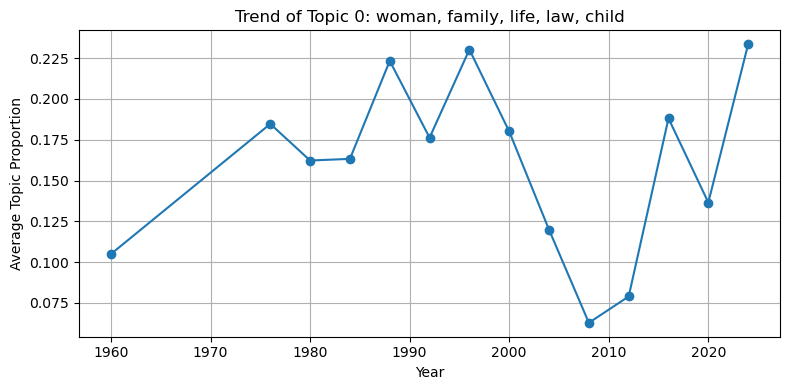

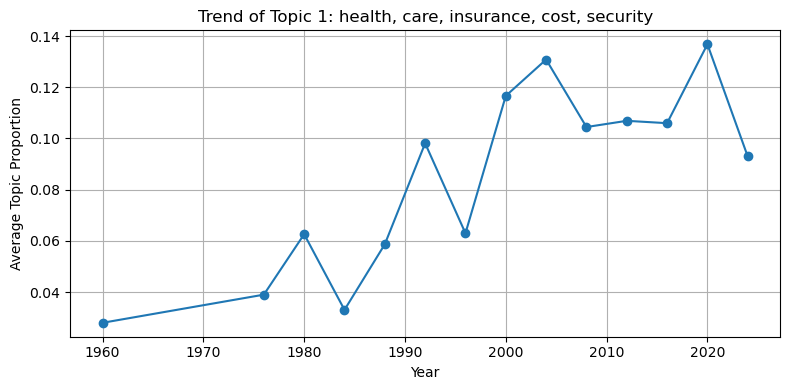

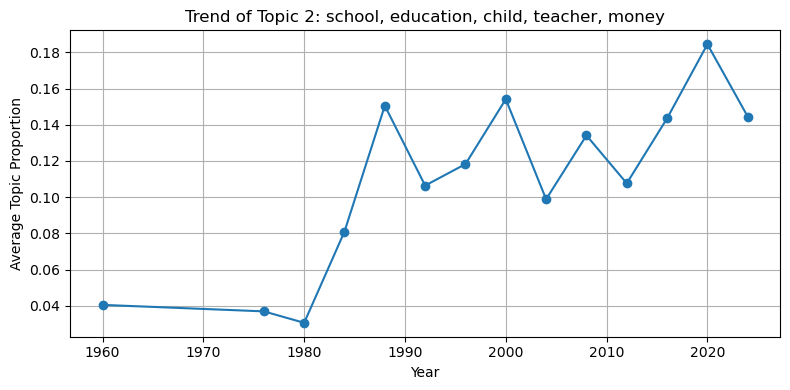

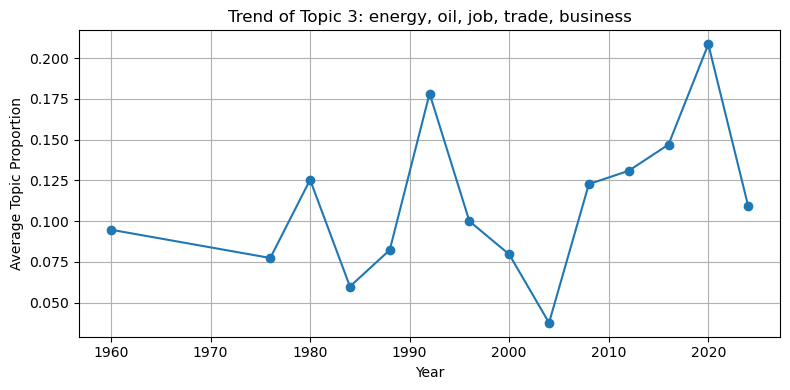

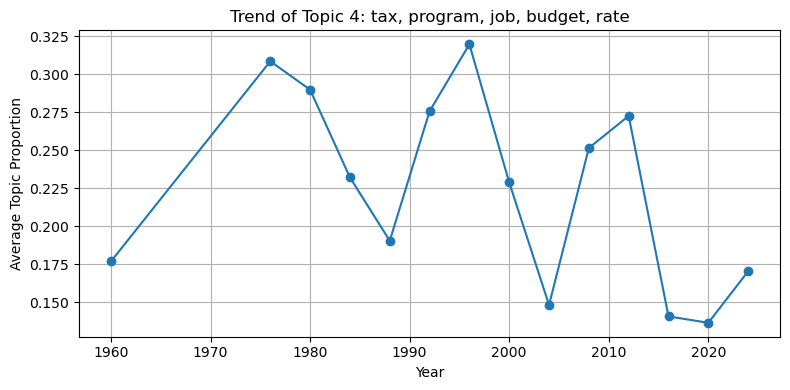

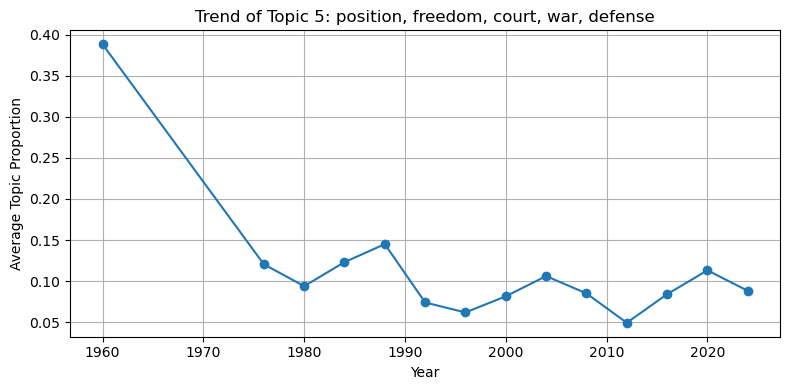

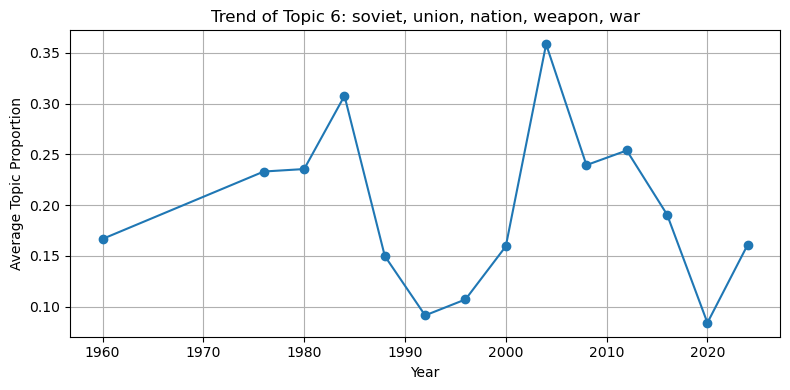

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get topic proportions per document
doc_topic_dists = [ldaseq.doc_topics(i) for i in range(len(all_docs))]
topic_df = pd.DataFrame(doc_topic_dists, columns=[f"Topic {i}" for i in range(ldaseq.num_topics)])

# Step 2: Match each doc to its year
years_per_doc = []
for year, docs in grouped.items():
    years_per_doc.extend([year] * len(docs))
topic_df["year"] = years_per_doc

# Step 3: Average topic proportions per year
topic_trends = topic_df.groupby("year").mean()

# Step 4: Get top 10 terms per topic (from first time slice)
topic_labels = []
for topic_id in range(ldaseq.num_topics):
    top_terms = ldaseq.print_topic(topic=topic_id, time=0, top_terms=5)
    label = f"Topic {topic_id}: " + ", ".join([term for term, _ in top_terms])
    topic_labels.append(label)

# Step 5: Plot each topic separately
for i, col in enumerate(topic_trends.columns):
    plt.figure(figsize=(8, 4))
    plt.plot(topic_trends.index, topic_trends[col], marker='o')
    plt.title(f"Trend of {topic_labels[i]}")
    plt.xlabel("Year")
    plt.ylabel("Average Topic Proportion")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [57]:
import pandas as pd
from gensim import corpora
from gensim.models.ldaseqmodel import LdaSeqModel

# Step 1: Preprocessing - tokenize and filter short texts
df_transcripts_v2 = df_transcripts.copy()
df_transcripts_v2 = df_transcripts_v2.dropna(subset=["cleaned_text"])
df_transcripts_v2["tokens"] = df_transcripts_v2["cleaned_text"].apply(lambda x: x.split())
df_transcripts_v2 = df_transcripts_v2[df_transcripts_v2["tokens"].apply(len) >= 5]

# Step 2: Group token lists by year
grouped_v2 = df_transcripts_v2.groupby("year")["tokens"].apply(list).sort_index()

# Step 3: Flatten into one doc per speech (not per year!)
all_docs_v2 = [doc for year_docs in grouped_v2 for doc in year_docs]
timeslices_v2 = [len(year_docs) for year_docs in grouped_v2]

# Step 4: Dictionary + filtering
dictionary_v2 = corpora.Dictionary(all_docs_v2)
corpus_v2 = [dictionary_v2.doc2bow(text) for text in all_docs_v2]

# Step 5: Train second Dynamic Topic Model
ldaseq_v2 = LdaSeqModel(
    corpus=corpus_v2,
    time_slice=timeslices_v2,
    id2word=dictionary_v2,
    num_topics=10,
    initialize='gensim',
    random_state=42
)

# Step 6: Print top terms in each topic over time
for topic_id in range(10):
    print(f"\n=== [Second Try] Topic {topic_id} ===")
    for t, year in enumerate(grouped_v2.index):
        terms = ldaseq_v2.print_topic(topic=topic_id, time=t, top_terms=10)
        print(f"Year {year}: {terms}")

/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



=== [Second Try] Topic 0 ===
Year 1960: [('security', 0.031001297429466713), ('social', 0.03044741078996968), ('energy', 0.021751232211173747), ('oil', 0.021717559085144618), ('dollar', 0.010245832515651618), ('power', 0.009651271091529313), ('land', 0.009195865432736759), ('clean', 0.009136574648993107), ('world', 0.009041820458035671), ('coal', 0.007919427146672672)]
Year 1976: [('security', 0.03215193237856626), ('social', 0.031043539119256208), ('energy', 0.02337707216783815), ('oil', 0.02242199085953488), ('land', 0.00957531517885718), ('dollar', 0.009548191979204486), ('clean', 0.00951053358632104), ('power', 0.009181277861432746), ('world', 0.009047808364910781), ('coal', 0.008194628117389857)]
Year 1980: [('security', 0.03504869778402398), ('social', 0.0344015796998729), ('energy', 0.0230925982790621), ('oil', 0.02261457895270642), ('clean', 0.010037745830841377), ('land', 0.009956180312774622), ('world', 0.009030556614225313), ('dollar', 0.008875606514849175), ('power', 0.008

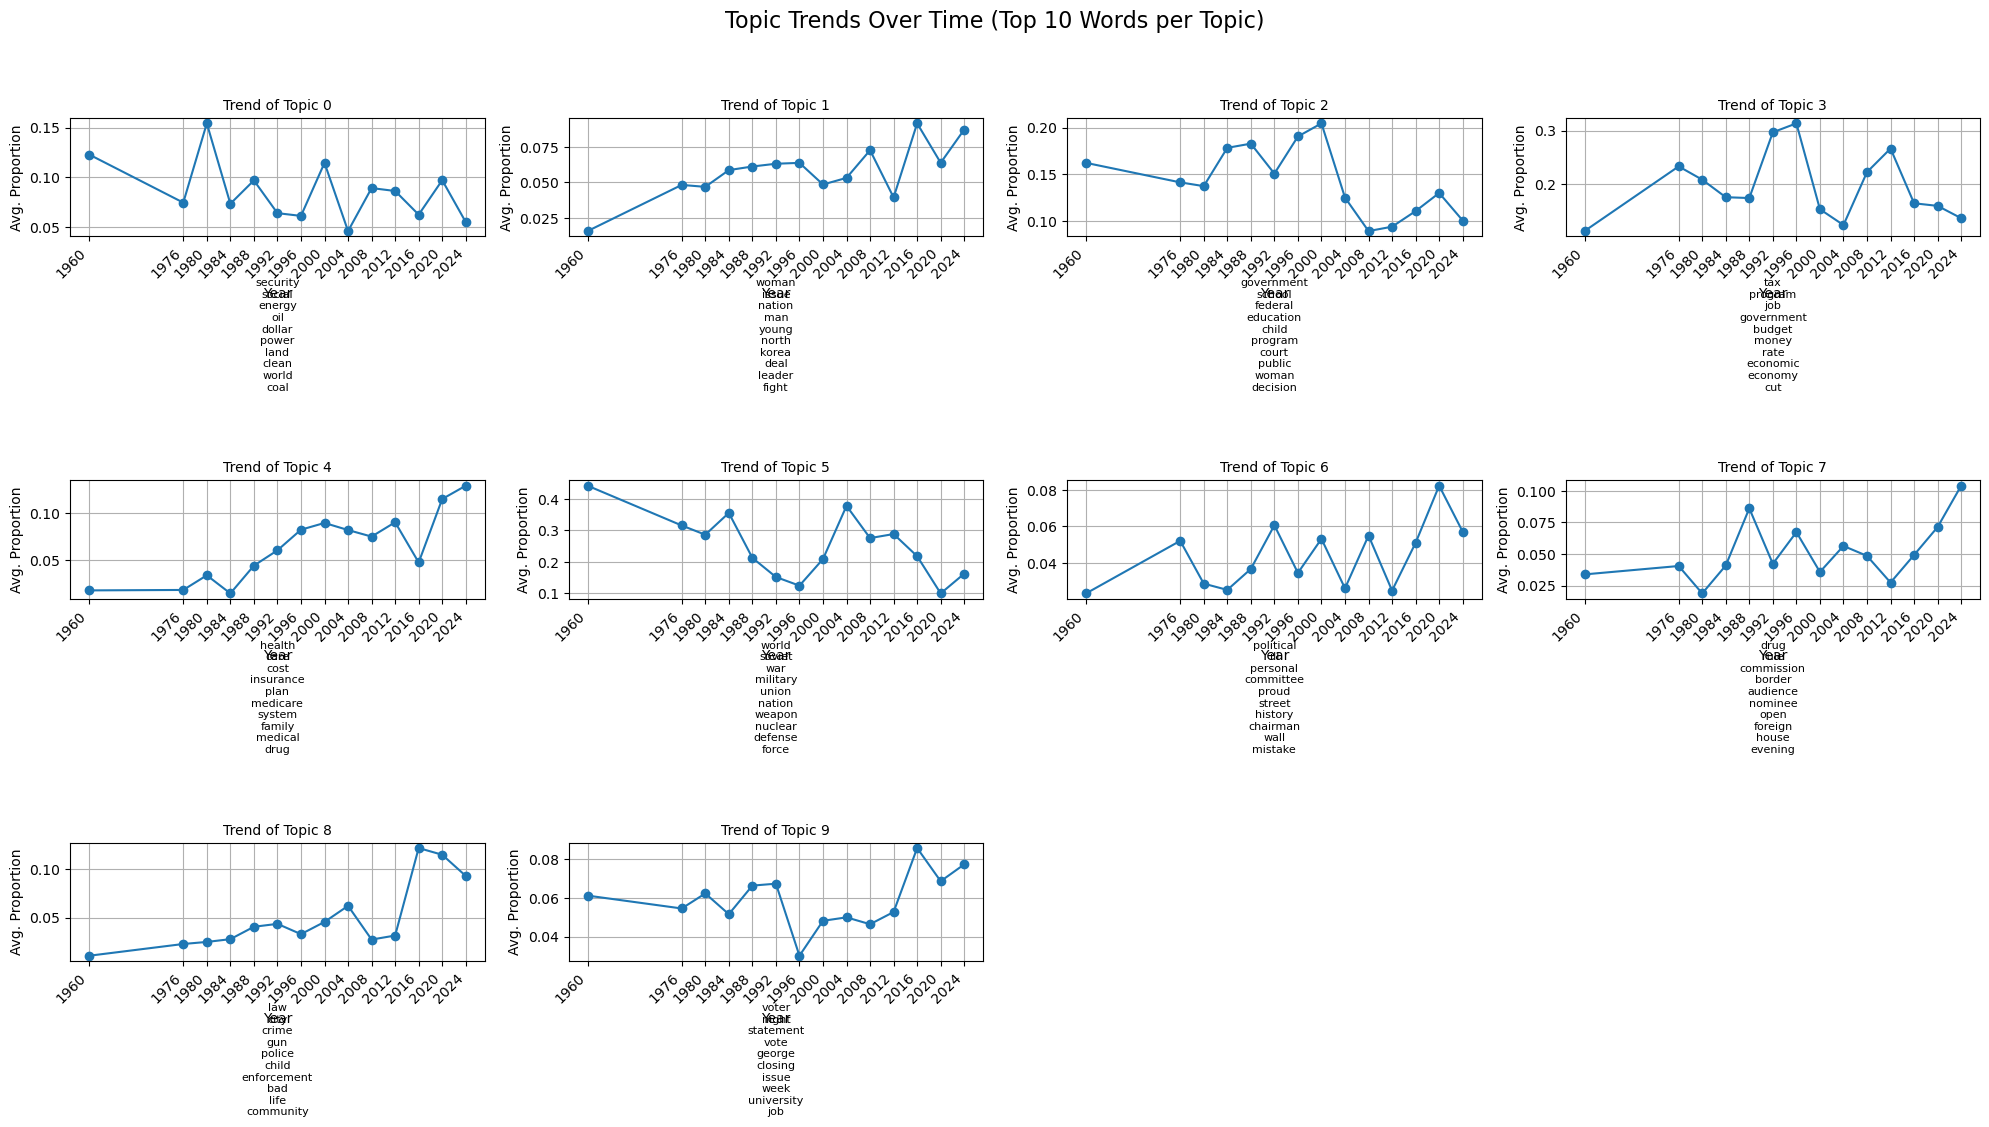

In [71]:
import matplotlib.pyplot as plt

# Prepare grid dimensions
num_topics = ldaseq_v2.num_topics
rows, cols = 3, 4  # Grid layout for 10 topics with extra slots (adjustable)
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

# Plot each topic
for i in range(len(axes)):
    ax = axes[i]
    if i < num_topics:
        ax.plot(topic_trends_v2.index, topic_trends_v2[f"Topic {i}"], marker='o')
        ax.set_title(f"Trend of Topic {i}", fontsize=10)
        ax.set_xlabel("Year")
        ax.set_ylabel("Avg. Proportion")
        ax.grid(True)
        ax.text(
            0.5, -0.35, topic_labels_v2[i],
            fontsize=8, ha='center', va='top',
            transform=ax.transAxes, wrap=True
        )
        ax.set_xticks(topic_trends_v2.index)
        ax.set_xticklabels(topic_trends_v2.index, rotation=45, ha='right')
    else:
        ax.axis("off")  # Hide unused plots if any

fig.suptitle("Topic Trends Over Time (Top 10 Words per Topic)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

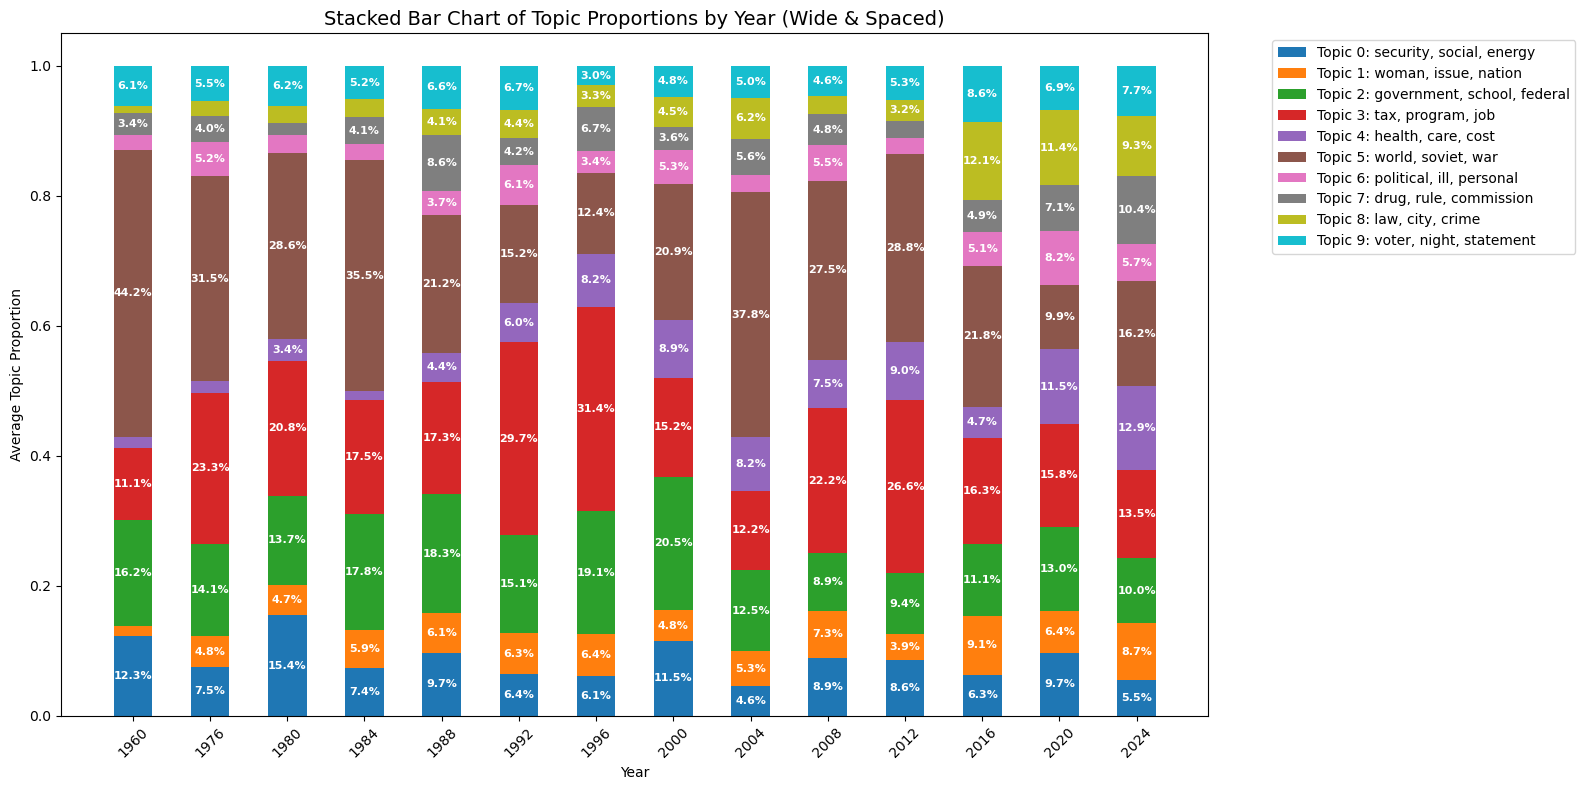

In [69]:
import matplotlib.pyplot as plt

# Prepare labels
legend_labels = []
for topic_id in range(ldaseq_v2.num_topics):
    top_terms = ldaseq_v2.print_topic(topic=topic_id, time=0, top_terms=3)
    short_label = f"Topic {topic_id}: " + ", ".join([term for term, _ in top_terms])
    legend_labels.append(short_label)

# Plot setup
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 1.5

years = topic_trends_v2.index.tolist()
spacing = 3  # controls how far apart the bars are
x_positions = [i * spacing for i in range(len(years))]  # spread out positions
bottoms = [0] * len(years)

# Draw stacked bars
for i in range(ldaseq_v2.num_topics):
    values = topic_trends_v2[f"Topic {i}"].values
    bars = ax.bar(x_positions, values, width=bar_width, bottom=bottoms, label=legend_labels[i])
    
    # Add % labels
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.03:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottoms[j] + height / 2,
                f"{height*100:.1f}%",
                ha='center',
                va='center',
                fontsize=8,  # ⬅️ increased font size here
                color='white',
                fontweight='bold'
            )
    bottoms = [sum(x) for x in zip(bottoms, values)]

# Customize axes
ax.set_title("Stacked Bar Chart of Topic Proportions by Year (Wide & Spaced)", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Average Topic Proportion")
ax.set_ylim(0, 1.05)

# Set x-axis labels to actual years, spaced accordingly
ax.set_xticks(x_positions)
ax.set_xticklabels(years, rotation=45)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
# Step 6: Define plotting function
def plot_topic_proportions(ldaseq_model, grouped_index):
    topic_proportions = ldaseq_model.gamma_  # shape: [years, topics]
    years = list(grouped_index)

    df_topic_props = pd.DataFrame(topic_proportions, columns=[f"Topic {i}" for i in range(ldaseq_model.num_topics)])
    df_topic_props["Year"] = years
    df_topic_props.set_index("Year", inplace=True)

    plt.figure(figsize=(14, 8))
    for topic in df_topic_props.columns:
        plt.plot(df_topic_props.index, df_topic_props[topic], marker='o', label=topic)

    plt.title("Topic Proportions Over Time")
    plt.xlabel("Year")
    plt.ylabel("Topic Proportion")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 7: Plot the topic proportions over time
plot_topic_proportions(ldaseq, grouped.index)

In [34]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaSeqModel

# Tokenize the cleaned text
df_transcripts['tokens'] = df_transcripts['cleaned_text'].apply(str.split)

In [35]:
# Group documents by year
documents_by_year = df_transcripts.groupby('year')['tokens'].apply(list)

# Flatten the list of documents and record the number of documents per year
all_documents = []
time_slices = []
for year_docs in documents_by_year:
    all_documents.extend(year_docs)
    time_slices.append(len(year_docs))

In [36]:
# Create a dictionary and corpus
dictionary = corpora.Dictionary(all_documents)
corpus = [dictionary.doc2bow(doc) for doc in all_documents]

In [ ]:
# Train the dynamic topic model
ldaseq = LdaSeqModel(corpus=corpus,
                     time_slice=time_slices,
                     id2word=dictionary,
                     num_topics=10)

/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))


In [ ]:
# Display topics for each time slice
for time in range(len(time_slices)):
    print(f"\nTime Slice {time}:")
    topics = ldaseq.print_topics(time=time)
    for topic_id, topic in topics:
        print(f"Topic {topic_id}: {topic}")

# LDA per Year

In [38]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 51.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]


In [43]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Step 1: Drop NA and convert cleaned text to a list of documents
documents = df_transcripts["cleaned_text"].dropna().astype(str).tolist()

# Step 2: Vectorize text
vectorizer = CountVectorizer(
    stop_words='english',
    max_df=0.2,  # Ignore very common words
    min_df=1     # Keep even rare words (you can raise this if you want to cut more noise)
)
doc_term_matrix = vectorizer.fit_transform(documents)

# Step 3: Fit LDA model
lda = LatentDirichletAllocation(
    n_components=10,
    random_state=42,
    max_iter=50,
    learning_method='batch',
    evaluate_every=10,
)
lda.fit(doc_term_matrix)

# Step 4: Show topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx}: {' + '.join(top_terms)}")

Topic 0: trade + voted + foreign + world + senate + farmer + ok + vote + dollar + house
Topic 1: crosstalk + woman + issue + court + law + drug + gun + crime + response + supreme
Topic 2: school + child + education + public + presidential + job + teacher + kid + running + parent
Topic 3: energy + oil + respond + true + coal + clean + plant + gas + sorry + closing
Topic 4: war + military + iraq + troop + sir + world + weapon + afghanistan + laughter + force
Topic 5: joe + china + bad + border + na + history + coming + gon + law + guy
Topic 6: nuclear + iran + weapon + climate + sanction + threat + hillary + deal + man + pakistan
Topic 7: soviet + union + decision + position + life + world + government + nation + arm + issue
Topic 8: world + russia + military + applause + war + nation + middle + peace + ally + iran
Topic 9: tax + cut + plan + health + care + job + pay + government + money + program


In [35]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaMallet  # Updated import

# Step 1: Group speeches by year (1 document per year)
yearly_docs = df_transcripts.groupby("year")["cleaned_text"] \
                            .apply(lambda texts: ' '.join(texts.dropna())) \
                            .reset_index()

# Step 2: Tokenize
texts = yearly_docs["cleaned_text"].apply(str.split).tolist()

# Step 3: Dictionary & Corpus
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 4: MALLET path (adjust to your system)
mallet_path = "/path/to/mallet-2.0.8/bin/mallet"  # Replace with actual path

# Step 5: Train MALLET LDA (uses Gibbs Sampling)
ldamallet = LdaMallet(
    mallet_path,
    corpus=corpus,
    num_topics=15,
    id2word=dictionary,
    random_seed=42,
    iterations=1000
)

# Step 6: Show topics
topics = ldamallet.show_topics(num_topics=-1, num_words=10)
for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")

ImportError: cannot import name 'LdaMallet' from 'gensim.models' (/opt/conda/lib/python3.12/site-packages/gensim/models/__init__.py)

In [ ]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from collections import defaultdict

# Ensure cleaned_text is tokenized
df_transcripts["tokens"] = df_transcripts["cleaned_text"].dropna().apply(str.split)

# Group data by year
grouped = df_transcripts.groupby("year")["tokens"].apply(list)

# Store topics per year
topics_per_year = {}

# Loop over each year and train LDA
for year, documents in grouped.items():
    # Flatten list of tokens (each document is a list of tokens)
    documents = [doc for doc in documents if isinstance(doc, list) and len(doc) > 0]

    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, passes=20)

    topics = lda_model.show_topics(num_topics=10, num_words=5, formatted=True)
    topics_per_year[year] = topics

# Display results
for year in sorted(topics_per_year):
    print(f"\n Year: {year}")
    for topic_id, topic_words in topics_per_year[year]:
        print(f"  Topic {topic_id}: {topic_words}")

# BERTopic per Year

In [66]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.5 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 81.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp312-cp312-linux_x86_64.whl size=844868 sha256=afcf272e55e175ed4129449d8a1280dcd1c9caa8ae15230ac5c9007c948a7838
  Stored in directory: /home/ucloud/.cache/pip/wheels/80/e7/bb/173ca0d8ce12718c4b5e6e01619c99653579b56969b97604b2
Successfully built hdbscan
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [bertopic]5/7 [sentence-transformers]


In [ ]:
from bertopic import BERTopic
import pandas as pd

In [ ]:
# Step 1: Drop NA and convert dialogues to string
texts = df_transcripts["dialogue"].dropna().astype(str).tolist()

# Step 2: Instantiate BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# Step 3: Fit the model on raw dialogue
topics, probs = topic_model.fit_transform(texts)

# Step 4: Show top 10 words for each topic
all_topics = topic_model.get_topics()

for topic_id, topic_words in all_topics.items():
    print(f"Topic {topic_id}: {topic_words[:10]}")

2025-05-21 20:33:23,981 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/262 [00:00<?, ?it/s]